In [1]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.1
1.4.1


In [1]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes

In [2]:
dataname = "m4_weekly_domain"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.


In [3]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [4]:
train_entry

{'start': Timestamp('1750-01-04 00:00:00', freq='W-SUN'),
 'target': array([ 1089.2 ,  1078.91,  1079.88, ..., 36565.18, 36565.18, 35397.16],
       dtype=float32),
 'feat_static_cat': array([1, 6]),
 'source': SourceContext(source=Span(path=WindowsPath('C:/Users/TM/.mxnet/gluon-ts/datasets/m4_weekly_domain/train/m4_weekly_domain_train.json'), line=1), row=1)}

### Plot Series

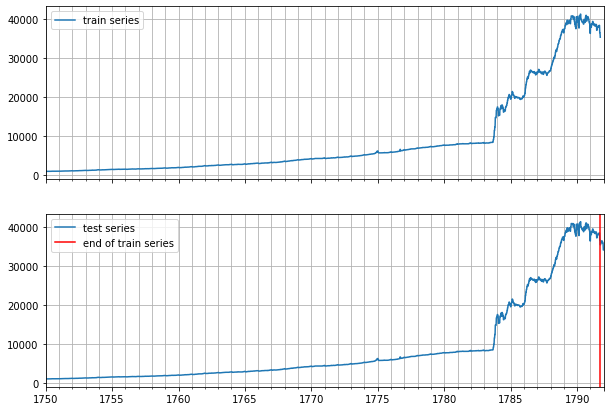

In [5]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## DeepAR - with 2 static features

In [7]:
# gluonts
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# DeepAREstimator
from gluonts.model.deepar import DeepAREstimator

INFO:root:Using CPU


In [50]:
data = "m4_weekly_domain"
dataset = get_dataset(data, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.


In [52]:
dataset.metadata.feat_static_cat

[<CategoricalFeatureInfo name='id' cardinality='359'>,
 <CategoricalFeatureInfo name='domain' cardinality='6'>]

In [53]:
[feat_static_cat.cardinality for feat_static_cat in dataset.metadata.feat_static_cat]

['359', '6']

In [54]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df


In [55]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_weekly_domain", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.03it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[0] Elapsed time 14.273 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.249107
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.75it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 12.919 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.842752
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.80it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[2] Elapsed time 12.833 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.715181
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.16it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[3] Elapsed time 13.982 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=5.881603
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.78it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[36] Elapsed time 14.751 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.766687
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  5.99it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[37] Elapsed time 16.704 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.821243
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.48it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[38] Elapsed time 15.433 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.897106
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.29it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[39] Elapsed time 13.720 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.811510
INFO:root:Epoch[40] Learning rate is 0.001
100%|█████

INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:13<00:00,  7.56it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[72] Elapsed time 13.239 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.694953
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:13<00:00,  7.40it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 13.523 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.739723
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:13<00:00,  7.62it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 13.131 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.727140
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  7.80it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[75] Elapsed time 12.839 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.697670
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:14<00:00,  7.01it/s, avg_epoch_

       MASE     sMAPE     MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.647697  0.086228  23.8142            0.063018            0.026098    42   

   epochs  num_batches  
0     100          100  
Seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.85it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 17.111 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.347654
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.74it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[1] Elapsed time 14.844 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.731935
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.43it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 15.560 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.617084
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.02it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[3] Elapsed time 12.471 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=5.795489
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.64it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[36] Elapsed time 17.750 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.825810
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.14it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[37] Elapsed time 14.019 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.795839
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.46it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[38] Elapsed time 19.174 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.824901
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:21<00:00,  4.68it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[39] Elapsed time 21.372 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.828118
INFO:root:Epoch[40] Learning rate is 0.001
100%|█████

100%|██████████| 100/100 [00:13<00:00,  7.62it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[72] Elapsed time 13.137 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.739076
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:14<00:00,  7.09it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[73] Elapsed time 14.116 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.702046
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  7.94it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[74] Elapsed time 12.600 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.712714
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:18<00:00,  5.44it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[75] Elapsed time 18.394 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.689485
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:16<00:00,  6.21it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[76] Elapsed time 16.111

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.623139  0.078814  25.410871            0.058675            0.027255   

   seed  epochs  num_batches  
0    43     100          100  
Seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.87it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[0] Elapsed time 14.564 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.278435
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.60it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 13.165 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.902134
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.18it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 16.214 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.797005
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.05it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 16.537 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=5.836489
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.99it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[36] Elapsed time 12.522 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.765837
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.18it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[37] Elapsed time 12.231 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.864322
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.29it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[38] Elapsed time 12.067 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.922741
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.33it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[39] Elapsed time 12.014 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.872650
INFO:root:Epoch[40] Learning rate is 0.001
100%|████

INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  7.85it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[72] Elapsed time 12.748 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.698361
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  7.95it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[73] Elapsed time 12.583 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.813056
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[74] Elapsed time 12.048 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.758513
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.32it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[75] Elapsed time 12.022 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.714763
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.427714  0.080337  21.225715            0.058028            0.027024   

   seed  epochs  num_batches  
0    44     100          100  
Seed: 45


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.56it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[0] Elapsed time 13.237 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.609840
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.26it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 12.109 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.858014
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.25it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[2] Elapsed time 12.128 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.593339
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.27it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[3] Elapsed time 13.769 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=5.894907
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.22it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[36] Elapsed time 12.172 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.827262
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.68it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[37] Elapsed time 17.614 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.828602
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.90it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[38] Elapsed time 12.673 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.810117
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.26it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[39] Elapsed time 12.115 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.813765
INFO:root:Epoch[40] Learning rate is 0.001
100%|████

INFO:root:Epoch[72] Elapsed time 11.798 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.724213
INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.94it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 11.190 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.736934
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.32it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[74] Elapsed time 12.029 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.719512
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.11it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[75] Elapsed time 12.338 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.758608
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.61it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[76] Elapsed time 11.614 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.731946
INFO

       MASE     sMAPE     MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.532896  0.082743  22.5323            0.061719            0.027687    45   

   epochs  num_batches  
0     100          100  
Seed: 46


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:26<00:00,  3.81it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[0] Elapsed time 26.285 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.185408
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:21<00:00,  4.69it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[1] Elapsed time 22.016 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.828843
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.85it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[2] Elapsed time 17.090 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.635259
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.18it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[3] Elapsed time 19.327 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=5.878035
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.53it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[36] Elapsed time 15.334 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.857788
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.39it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[37] Elapsed time 18.557 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.758439
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.23it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[38] Elapsed time 16.067 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.822589
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:20<00:00,  4.78it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[39] Elapsed time 20.944 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.782406
INFO:root:Epoch[40] Learning rate is 0.001
100%|████

INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:17<00:00,  5.81it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[72] Elapsed time 17.219 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.780194
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:19<00:00,  5.07it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[73] Elapsed time 19.739 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.706591
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:15<00:00,  6.46it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 15.487 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.727589
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:15<00:00,  6.44it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[75] Elapsed time 15.528 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.755305
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:19<00:00,  5.21it/s, avg_epoch

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.555657  0.080359  20.955645            0.059487            0.027132   

   seed  epochs  num_batches  
0    46     100          100  
Seed: 47


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.85it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[0] Elapsed time 12.750 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.304906
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.02it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[1] Elapsed time 16.609 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.811662
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:23<00:00,  4.23it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[2] Elapsed time 23.662 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.671203
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.70it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[3] Elapsed time 14.940 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.99it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[36] Elapsed time 11.134 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.868941
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.12it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[37] Elapsed time 14.047 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.868302
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.53it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[38] Elapsed time 15.324 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.816277
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.77it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[39] Elapsed time 17.348 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.855502
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.30it/s, avg_epoch_loss=5.82

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.743866
INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.66it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[73] Elapsed time 17.673 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.751390
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.28it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 15.943 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.732123
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  5.96it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[75] Elapsed time 16.813 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.771483
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.14it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[76] Elapsed time 16.323 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.697409
INFO:root:Epoch[77] Learning rate is 0.001
100%|█████

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.974403  0.085861  25.400273            0.062869            0.027911   

   seed  epochs  num_batches  
0    47     100          100  
Seed: 48


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.55it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[0] Elapsed time 15.280 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.478983
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.93it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[1] Elapsed time 14.440 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.849439
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.37it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 13.575 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.621795
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.38it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 13.560 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=5.912799
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.10it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[36] Elapsed time 12.353 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.833645
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.83it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[37] Elapsed time 12.777 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.835555
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.47it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[38] Elapsed time 13.399 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.870551
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.12it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[39] Elapsed time 12.322 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.865198
INFO:root:Epoch[40] Learning rate is 0.001
100%|████

100%|██████████| 100/100 [00:12<00:00,  7.71it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[72] Elapsed time 12.972 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.740380
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:13<00:00,  7.50it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[73] Elapsed time 13.341 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.711495
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.03it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[74] Elapsed time 12.467 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.772928
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  7.99it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[75] Elapsed time 12.520 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.710616
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:13<00:00,  7.54it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[76] Elapsed time 13.26

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.688655  0.078402  23.730044            0.058814            0.026328   

   seed  epochs  num_batches  
0    48     100          100  
Seed: 49


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.06it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[0] Elapsed time 16.499 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.274832
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.84it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 12.758 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.901552
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.18it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[2] Elapsed time 12.233 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.640127
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.06it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[3] Elapsed time 12.418 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=5.838849
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.51it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[36] Elapsed time 15.365 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.887684
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.32it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[37] Elapsed time 12.022 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.888037
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.20it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[38] Elapsed time 12.202 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.882983
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.68it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[39] Elapsed time 13.021 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.882312
INFO:root:Epoch[40] Learning rate is 0.001
100%|████

100%|██████████| 100/100 [00:12<00:00,  8.03it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[72] Elapsed time 12.462 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.745766
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:13<00:00,  7.33it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[73] Elapsed time 13.656 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.750547
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:14<00:00,  6.96it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 14.374 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.732204
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[75] Elapsed time 12.046 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.726268
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.03it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[76] Elapsed time 12.4

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.877221  0.088606  27.282367            0.064581            0.029408   

   seed  epochs  num_batches  
0    49     100          100  
Seed: 50


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.80it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[0] Elapsed time 12.827 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.228729
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.19it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 12.215 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.835405
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.23it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[2] Elapsed time 12.155 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.737825
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.05it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[3] Elapsed time 14.201 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=5.856368
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.59it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[36] Elapsed time 17.893 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.924168
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.72it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[37] Elapsed time 14.894 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.898251
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.27it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[38] Elapsed time 13.760 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.891523
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.12it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[39] Elapsed time 12.321 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.918667
INFO:root:Epoch[40] Learning rate is 0.001
100%|█████

INFO:root:Epoch[72] Elapsed time 14.986 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.816377
INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.27it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[73] Elapsed time 12.107 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.771947
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.65it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 13.079 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.725435
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.79it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[75] Elapsed time 12.838 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.749768
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.01it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[76] Elapsed time 12.491 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.744976
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.921541  0.082299  35.811205            0.062046            0.031452   

   seed  epochs  num_batches  
0    50     100          100  
Seed: 51


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.77it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[0] Elapsed time 14.784 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.214874
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.58it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[1] Elapsed time 13.193 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.766113
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.08it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 12.378 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.616317
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.06it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[3] Elapsed time 12.407 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=5.891840
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.26it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[36] Elapsed time 12.120 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.794257
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.84it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[37] Elapsed time 12.760 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.827171
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.64it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[38] Elapsed time 13.101 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.839300
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.49it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[39] Elapsed time 13.361 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.864915
INFO:root:Epoch[40] Learning rate is 0.001
100%|████

100%|██████████| 100/100 [00:12<00:00,  8.21it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[72] Elapsed time 12.190 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.742276
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.25it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 12.126 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.726250
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.20it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[74] Elapsed time 12.200 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.687006
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.11it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[75] Elapsed time 12.338 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.660340
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.24it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[76] Elapsed time 12.1

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.896752  0.082645  27.99451            0.062774            0.027616    51   

   epochs  num_batches  
0     100          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,2.647697,0.086228,23.814200,0.063018,0.026098,42,100,100
0,2.623139,0.078814,25.410871,0.058675,0.027255,43,100,100
0,2.427714,0.080337,21.225715,0.058028,0.027024,44,100,100
0,2.532896,0.082743,22.532300,0.061719,0.027687,45,100,100
0,2.555657,0.080359,20.955645,0.059487,0.027132,46,100,100
0,2.974403,0.085861,25.400273,0.062869,0.027911,47,100,100
0,2.688655,0.078402,23.730044,0.058814,0.026328,48,100,100
0,2.877221,0.088606,27.282367,0.064581,0.029408,49,100,100
0,2.921541,0.082299,35.811205,0.062046,0.031452,50,100,100
0,2.896752,0.082645,27.994510,0.062774,0.027616,51,100,100


In [56]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_weekly", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.07it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[0] Elapsed time 12.400 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.333318
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.14it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[1] Elapsed time 14.011 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.825292
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[2] Elapsed time 12.038 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.714820
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.41it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 11.897 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.51

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.04it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[36] Elapsed time 14.218 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.835487
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.97it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[37] Elapsed time 14.355 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.861541
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.56it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[38] Elapsed time 13.231 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.865267
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.60it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[39] Elapsed time 13.164 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.887866
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.72it/s, avg_epoch_loss=5.86

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.723969
INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.06it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[73] Elapsed time 12.410 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.720925
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.44it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[74] Elapsed time 13.449 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.746610
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.48it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[75] Elapsed time 15.443 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.713437
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.17it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[76] Elapsed time 16.214 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.730055
INFO:root:Epoch[77] Learning rate is 0.001
100%|████

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.675979  0.08395  29.957781            0.062653            0.031221    42   

   epochs  num_batches  
0     100          100  
Seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:56<00:00,  1.77it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[0] Elapsed time 56.605 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.661190
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:44<00:00,  2.25it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[1] Elapsed time 44.491 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.848373
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:30<00:00,  3.33it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[2] Elapsed time 30.095 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.670903
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [01:06<00:00,  1.50it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[3] Elapsed time 66.898 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.54

INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:24<00:00,  4.14it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[41] Elapsed time 24.181 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=5.872640
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 100/100 [00:28<00:00,  3.47it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[42] Elapsed time 28.797 seconds
INFO:root:Epoch[42] Evaluation metric 'epoch_loss'=5.834545
INFO:root:Epoch[43] Learning rate is 0.001
100%|██████████| 100/100 [00:30<00:00,  3.30it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[43] Elapsed time 30.334 seconds
INFO:root:Epoch[43] Evaluation metric 'epoch_loss'=5.860839
INFO:root:Epoch[44] Learning rate is 0.001
100%|██████████| 100/100 [00:30<00:00,  3.32it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[44] Elapsed time 30.114 seconds
INFO:root:Epoch[44] Evaluation metric 'epoch_loss'=5.897112
INFO:root:Epoch[45] Learning rate is 0.001
100%|██████████| 100/100 [00:23<00:00,  4.23it/s, avg_epoch_loss=5.81]

INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.774737
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:29<00:00,  3.36it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[78] Elapsed time 29.818 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.755154
INFO:root:Loading parameters from best epoch (68)
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 100/100 [00:32<00:00,  3.10it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[79] Elapsed time 32.275 seconds
INFO:root:Epoch[79] Evaluation metric 'epoch_loss'=5.725712
INFO:root:Epoch[80] Learning rate is 0.0005
100%|██████████| 100/100 [00:25<00:00,  3.98it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[80] Elapsed time 25.112 seconds
INFO:root:Epoch[80] Evaluation metric 'epoch_loss'=5.722851
INFO:root:Epoch[81] Learning rate is 0.0005
100%|██████████| 100/100 [00:28<00:00,  3.56it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[81] Elapsed time 28.113 seconds
INFO:root:Epoch[81] Evaluation metric 'epoch_loss'=5.708067

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.685703  0.083277  28.105718            0.061119            0.028726   

   seed  epochs  num_batches  
0    43     100          100  
Seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:24<00:00,  4.11it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 24.335 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.855830
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:22<00:00,  4.48it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[1] Elapsed time 22.314 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.882931
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:22<00:00,  4.39it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[2] Elapsed time 22.776 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.653240
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:22<00:00,  4.47it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[3] Elapsed time 22.391 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.41

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.46it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[36] Elapsed time 8.058 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.808795
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.17it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[37] Elapsed time 8.221 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.813696
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.71it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[38] Elapsed time 7.874 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.849112
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.12it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[39] Elapsed time 7.630 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.854930
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.23it/s, avg_epoch_loss=5.85]
IN

INFO:root:Epoch[72] Elapsed time 7.066 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.672958
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 14.02it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[73] Elapsed time 7.139 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.809516
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 13.96it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[74] Elapsed time 7.173 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.735798
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.69it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[75] Elapsed time 7.888 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.694645
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 14.16it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[76] Elapsed time 7.067 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.745840
I

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.553431  0.085053  22.71406            0.061923            0.028575    44   

   epochs  num_batches  
0     100          100  
Seed: 45


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.61it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[0] Elapsed time 7.355 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.407360
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.98it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1] Elapsed time 7.157 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.794106
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.27it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 7.016 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.622933
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.26it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[3] Elapsed time 7.017 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.543541

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.26it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[36] Elapsed time 7.020 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.925147
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.38it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[37] Elapsed time 6.963 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.898626
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.32it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[38] Elapsed time 6.992 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.864582
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.36it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[39] Elapsed time 6.969 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.921531
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.81it/s, avg_epoch_loss=5.85]
INF

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.14it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[73] Elapsed time 7.077 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.695781
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.33it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[74] Elapsed time 6.984 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.764650
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.32it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[75] Elapsed time 7.518 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.778142
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.50it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[76] Elapsed time 8.708 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.746556
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.35it/s, avg_epoch_loss=5.77]
INF

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.551216  0.083366  23.017125            0.061141            0.026905   

   seed  epochs  num_batches  
0    45     100          100  
Seed: 46


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.00it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[0] Elapsed time 7.152 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.326514
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.81it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[1] Elapsed time 7.248 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.853384
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.31it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 6.992 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.617557
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.40it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[3] Elapsed time 6.951 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.553704

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.40it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[36] Elapsed time 6.951 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.896545
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.38it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[37] Elapsed time 6.962 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.803066
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.93it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[38] Elapsed time 8.388 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.827635
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.24it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[39] Elapsed time 7.561 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.880891
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.24it/s, avg_epoch_loss=5.83]
INFO

100%|██████████| 100/100 [00:08<00:00, 11.13it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[72] Elapsed time 9.000 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.788570
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.40it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[73] Elapsed time 6.951 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.714600
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.60it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[74] Elapsed time 6.857 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.737887
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.42it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[75] Elapsed time 6.942 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.770974
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.43it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[76] Elapsed time 6.93

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.480305  0.092277  21.864018             0.06577            0.027685   

   seed  epochs  num_batches  
0    46     100          100  
Seed: 47


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.86it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[0] Elapsed time 7.226 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.307405
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.18it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1] Elapsed time 7.596 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.824542
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.30it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[2] Elapsed time 8.141 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.645937
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.44it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 6.929 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.514965

100%|██████████| 100/100 [00:07<00:00, 14.26it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[36] Elapsed time 7.019 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.845107
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.18it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[37] Elapsed time 8.215 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.890040
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.88it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[38] Elapsed time 7.210 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.795883
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.03it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[39] Elapsed time 7.136 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.839674
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.49it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[40] Elapsed time 6.905 seconds

INFO:root:Epoch[72] Elapsed time 6.922 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.744076
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.65it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 6.830 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.741253
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.51it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[74] Elapsed time 6.898 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.766386
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.84it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[75] Elapsed time 6.746 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.730355
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:06<00:00, 14.82it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[76] Elapsed time 6.752 seconds
INFO:root:

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.749931  0.083731  28.312247            0.060692            0.027068   

   seed  epochs  num_batches  
0    47     100          100  
Seed: 48


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.18it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[0] Elapsed time 7.059 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.429280
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.85it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1] Elapsed time 6.740 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.820354
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.68it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[2] Elapsed time 6.817 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.670751
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.88it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 6.727 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.511574

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.68it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[36] Elapsed time 6.816 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.811891
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.56it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[37] Elapsed time 6.873 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.759743
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.49it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[38] Elapsed time 6.909 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.808154
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.21it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[39] Elapsed time 7.578 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.827410
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.62it/s, avg_epoch_loss=5.82]
IN

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.721156
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:07<00:00, 13.94it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[73] Elapsed time 7.177 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.703478
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.60it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[74] Elapsed time 6.855 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.756778
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.60it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[75] Elapsed time 6.856 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.689615
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.59it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[76] Elapsed time 6.860 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.692570
INFO:root:Epoch[77] Learning rate is 0.0005
100%|████

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.700239  0.085821  27.460034            0.063158            0.029634   

   seed  epochs  num_batches  
0    48     100          100  
Seed: 49


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.27it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[0] Elapsed time 7.013 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.449640
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.13it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 7.083 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.897352
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.04it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 6.655 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.623805
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.22it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[3] Elapsed time 7.041 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.452351


INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.68it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[36] Elapsed time 6.819 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.897655
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.40it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[37] Elapsed time 6.951 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.869305
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.58it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[38] Elapsed time 6.866 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.906468
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.64it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[39] Elapsed time 6.837 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.842229
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.74it/s, avg_epoch_loss=5.84]
INF

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.722645
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.89it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[73] Elapsed time 6.721 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.746408
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.81it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[74] Elapsed time 6.759 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.741140
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 15.01it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[75] Elapsed time 6.669 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.728174
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:07<00:00, 14.21it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[76] Elapsed time 7.045 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.710951
INFO:root:Epoch[77] Learning rate is 0.0005
100%|███

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.152744  0.099731  36.241247            0.072664            0.036317   

   seed  epochs  num_batches  
0    49     100          100  
Seed: 50


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.32it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 6.992 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.352016
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.63it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 6.842 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.862839
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.46it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[2] Elapsed time 6.921 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.723205
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.80it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[3] Elapsed time 6.762 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.574496

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.81it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[36] Elapsed time 6.760 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.892348
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.17it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[37] Elapsed time 7.064 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.905834
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.89it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[38] Elapsed time 6.724 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.900999
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.49it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[39] Elapsed time 6.904 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.886418
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.83it/s, avg_epoch_loss=5.86]
INF

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.784105
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.95it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[73] Elapsed time 6.692 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.768236
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.88it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 6.727 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.734738
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.85it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[75] Elapsed time 6.740 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.749332
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.79it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[76] Elapsed time 6.768 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.759117
I

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.551079  0.086004  22.716032            0.061955            0.025813   

   seed  epochs  num_batches  
0    50     100          100  
Seed: 51


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.11it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[0] Elapsed time 10.991 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.317519
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.66it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[1] Elapsed time 13.063 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.879192
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.95it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[2] Elapsed time 10.060 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.654424
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.61it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 10.408 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.51

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.21it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[36] Elapsed time 7.047 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.821010
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.31it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[37] Elapsed time 6.993 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.914626
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.40it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[38] Elapsed time 6.951 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.859169
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.39it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[39] Elapsed time 8.081 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.886848
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.30it/s, avg_epoch_loss=5.81]
IN

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.29it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 7.005 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.742055
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.84it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[74] Elapsed time 7.237 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.718351
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.35it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[75] Elapsed time 6.976 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.668933
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.34it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[76] Elapsed time 6.978 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.721582
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.23it/s, avg_epoch_loss=5.72]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.938536  0.088076  26.387251            0.067153            0.030391   

   seed  epochs  num_batches  
0    51     100          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,2.675979,0.083950,29.957781,0.062653,0.031221,42,100,100
0,2.685703,0.083277,28.105718,0.061119,0.028726,43,100,100
0,2.553431,0.085053,22.714060,0.061923,0.028575,44,100,100
0,2.551216,0.083366,23.017125,0.061141,0.026905,45,100,100
0,2.480305,0.092277,21.864018,0.065770,0.027685,46,100,100
0,2.749931,0.083731,28.312247,0.060692,0.027068,47,100,100
0,2.700239,0.085821,27.460034,0.063158,0.029634,48,100,100
0,3.152744,0.099731,36.241247,0.072664,0.036317,49,100,100
0,2.551079,0.086004,22.716032,0.061955,0.025813,50,100,100
0,2.938536,0.088076,26.387251,0.067153,0.030391,51,100,100


### m4_daily vs. m4_daily domain

- reload `utils`
- test `m4_daily` vs. `m4_daily_domain`
- ten trials each, 
 - `epochs=100`, `num_batches_per_epoch=100`